# Learning with ensembles

Majority voting simply means that we select the class
label that has been predicted by the majority of classifiers, that is, received more than
50 percent of the votes. Strictly speaking, the term majority vote refers to binary
class settings only. However, it is easy to generalize the majority voting principle to
multi-class settings, which is called plurality voting. Here, we select the class label
that received the most votes (mode). 

The error probability of an ensemble is always
better than the error of an individual base classifier as long as the base classifiers
perform better than random guessing (ε < 0.5 )

In [1]:
from scipy.misc import comb
import math

def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * (error ** k) * ((1-error) ** (n_classifier - k)) for k 
            in range(k_start, n_classifier + 1)]
    return sum(probs)

ensemble_error(n_classifier = 11, error = 0.25)

0.034327507019042969

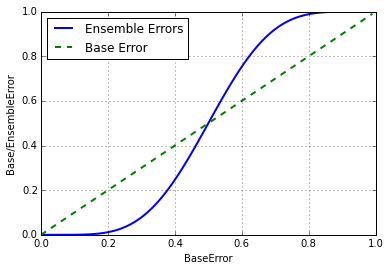

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.0, 0.01)
ens_errors = [ensemble_error(n_classifier = 11, error = err) for err in error_range]

plt.plot(error_range, ens_errors, label = 'Ensemble Errors', linewidth = 2)
plt.plot(error_range, error_range, linestyle = '--', label = 'Base Error', linewidth = 2)
plt.xlabel('BaseError')
plt.ylabel('Base/EnsembleError')
plt.grid()
plt.legend(loc = 'upper left')
plt.show()

# Implementing a simple majority vote classifier

In [5]:
#weighted majority rule by applying weights to class labels
import numpy as np
np.argmax(np.bincount([0, 0, 1], weights = [0.2, 0.2, 0.6]))

1

Using the predicted class probabilities instead
of the class labels for majority voting can be useful if the classifiers in our ensemble
are well calibrated.

In [7]:
#weighted majority classifier by applying weights to class probabilities
ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p = np.average(ex, axis = 0, weights = [0.2, 0.2, 0.6])
print (p)
np.argmax(p)

[ 0.58  0.42]


0

In [40]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """
    A majority vote ensemble classifier
    
    Parameters
    ----------
    classifiers : array-like of shape = [n_classifiers]
        Different classifiers to be fed into the ensemble
    
    vote : str, {'classlabel', 'probability'}
        Default: 'classlabel'
        If 'classlabel', the prediction is based on argmax of class labels. If 'probability', 
        the prediction is based on argmax of sum of probabilities used to predict the class
        (recommended for caliberated classifiers)
        
    weights: array of shape = [n_classifiers]
        Optional, default: None
        If a list of int or float values are provided, classifiers are weighted by importance
        Uses uniform weights if 'weights = None'
    """
    
    def __init__(self, classifiers, vote = 'classlabel', weights = None):
        self.classifiers = classifiers
        self.vote = vote
        self.weights = weights
        self.named_classifiers = {key : value for key, value in _name_estimators(classifiers)}
        
    def fit(self, X, y):
        """
        Fit classifiers
        
        Parameters
        ----------
        X : array of sparse matrix
            shape = [n_samples, n_features]
            matrix of training samples
            
        y : array of shape = [n_samples]
            Vector of target class labels
        
        Returns
        --------
        self : object
        """
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """
        Predict class labels for X
        
        Parameters
        -----------
        X : array like sparse matrix of shape = [n_samples, n_features]
            Matrix of training samples
        
        Returns
        --------
        maj_vote: array of shape = [n_samples]
            Predicted class labels
        """
        
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis = 1)
        
        else: 
            predictions = np.array([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights = self.weights)), axis = 1, arr = predictions)
            maj_vote = self.labelenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X
        
        Parameters
        ----------
        X : array-like sparse matrix of shape = [n_samples, n_features]
            Training matrix
        
        Returns
        -------
        avg_proba : array of shape = [n_samples, n_classes]
            Weighted average probability for each class per sample
        """
        proba = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(proba, axis = 0, weights = self.weights)
        return avg_proba
    
    def get_params(self, deep = True):
        """
        Get classifier param names for GridSearch
        """
        if not deep: 
            return super(MajorityVoteClassifier, self).get_params(deep = False)
        else: 
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep = True)):
                    out['%s__%s' %(name, key)] = value
            return out
    

### Combining different algorithms for classification with majority vote

In [31]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#prepare dataset
iris = datasets.load_iris()
X, y = iris.data[50: , [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, 
                                                   random_state = 1)

In [32]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty = 'l2', C = 0.001, random_state = 0)
clf2 = DecisionTreeClassifier(max_depth = 1, criterion = 'entropy', random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 1, p = 2, metric = 'minkowski')

#pipeline LogisticRegression and KNN as features need to be scaled for them
pipe1 = Pipeline([('sc', StandardScaler()), 
                 ('clf', clf1)])
pipe3 = Pipeline([('sc', StandardScaler()), 
                 ('clf', clf3)])
clf_labels = ['Logisitic Regression', 'Decision Tree', 'KNN']
print ('10-fold cross validation : \n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = 10, 
                            scoring = 'roc_auc')
    print ('ROC-AUC: %.2f +/- %.2f [%s]' %(scores.mean(), scores.std(), label))
    

10-fold cross validation : 

ROC-AUC: 0.92 +/- 0.20 [Logisitic Regression]
ROC-AUC: 0.92 +/- 0.15 [Decision Tree]
ROC-AUC: 0.93 +/- 0.10 [KNN]


In [42]:
mv_clf = MajorityVoteClassifier(classifiers = [pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator = clf, X = X_train, y = y_train, 
                            cv = 10, scoring = 'roc_auc')
    print ('Accuracy: %.2f +/ %.2f [%s]' %(scores.mean(), scores.std(), label))

Accuracy: 0.92 +/ 0.20 [Logisitic Regression]
Accuracy: 0.92 +/ 0.15 [Decision Tree]
Accuracy: 0.93 +/ 0.10 [KNN]
Accuracy: 0.97 +/ 0.10 [Majority Voting]


# Evaluating and tuning the ensemble classifier

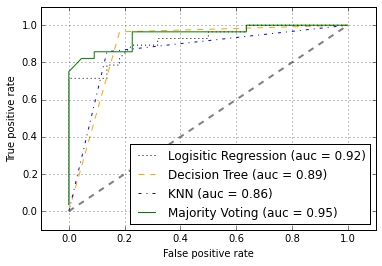

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred)
    roc_auc = auc(x = fpr, y = tpr)
    plt.plot(fpr, tpr, color = clr, linestyle = ls, 
             label = '%s (auc = %.2f)' %(label, roc_auc))
plt.grid()
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', linewidth = 2)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim([-0.1, 1.1])
plt.ylim ([-0.1, 1.1])
plt.show()

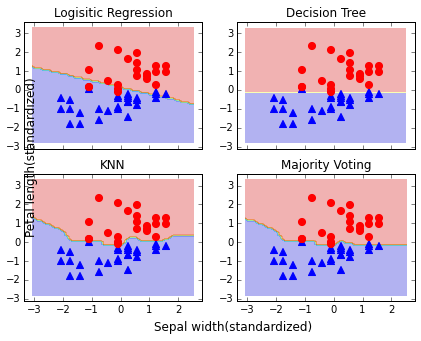

In [35]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), 
                    np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 2, ncols = 2, sharex = 'col', figsize = (7, 5))
for idx, clf, tt in zip(product([0,1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, z, alpha = 0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0], 
                                 X_train_std[y_train == 0, 1], 
                                 color = 'blue', marker = '^', s = 50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0], 
                                 X_train_std[y_train == 1, 1], 
                                 color = 'red', marker = 'o', s = 50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5, s = 'Sepal width(standardized)', ha = 'center', va = 'center', 
        fontsize = 12)
plt.text(-10.5, 4.5, s = 'Petal length(standardized)', ha = 'center', va = 'center',
           fontsize = 12, rotation = 90)
plt.show()

    

In [43]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_

In [44]:
from sklearn.grid_search import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2], 
    'pipeline-1__clf__C': [0.001, 0.1, 100.0]
}
grid = GridSearchCV(estimator = mv_clf, param_grid = params, cv = 10, scoring = 'roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=0, solver='liblin...ze=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform'))])],
            vote='classlabel', weights=None),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'pipeline-1__clf__C': [0.001, 0.1, 100.0], 'decisiontreeclassifier__max_depth': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)

In [45]:
for params, mean_score, scores in grid.grid_scores_:
    print ('%0.3f +- %.2f %r' %(mean_score, scores.std() / 2, params))

0.967 +- 0.05 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 1}
0.967 +- 0.05 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 1}
1.000 +- 0.00 {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 1}
0.967 +- 0.05 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 2}
0.967 +- 0.05 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 2}
1.000 +- 0.00 {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 2}


In [46]:
print ('Best params: %s' %grid.best_params_)
print ('Accuracy: %.3f' %grid.best_score_)

Best params: {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 1}
Accuracy: 1.000


# Bagging – building an ensemble of classifiers from bootstrap samples

Instead of using the same training set to fit the individual classifiers in the
ensemble, we draw bootstrap samples (random samples with replacement) from the
initial training set, which is why bagging is also known as bootstrap aggregating.

Random
forests are a special case of bagging where we also use random feature subsets
to fit the individual decision trees. 

The bagging algorithm can be an
effective approach to reduce the variance of a model. However, bagging is ineffective
in reducing model bias, which is why we want to choose an ensemble of classifiers
with low bias, for example, unpruned decision trees.

In [47]:
import pandas as pd

#create dataset
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', 
                     header = None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic Acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 
                  'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue','OD280/OD315 of diluted wines', 'Proline']
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [48]:
#label encode class labels to integers and create train and test datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)

In [49]:
#create a bagging ensemble model
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = None)
bag = BaggingClassifier(base_estimator = tree, n_estimators = 500, max_samples = 1.0, 
                       max_features = 1.0, bootstrap = True, bootstrap_features = False,
                       n_jobs = -1, random_state = 1)


In [51]:
#compute and compare accuracies of single decision tree vs bagging ensemble of trees
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_true = y_train, y_pred = y_train_pred)
tree_test = accuracy_score(y_true = y_test, y_pred = y_test_pred)
print ('Decision tree train/test accuracies %.3f / %.3f' %(tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_true = y_train, y_pred = y_train_pred)
bag_test = accuracy_score(y_true = y_test, y_pred = y_test_pred)
print ('Bagging train/test accuracies %.3f / %.3f' %(bag_train, bag_test))

Decision tree train/test accuracies 1.000 / 0.833
Bagging train/test accuracies 1.000 / 0.896


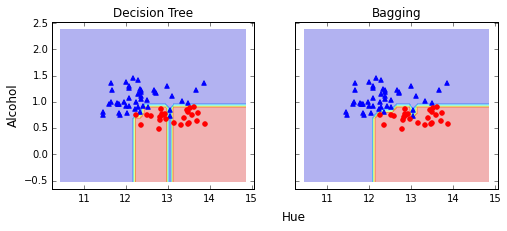

In [52]:
#plot and compare decision regions of tree vs bagging classifier
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 1, ncols = 2, sharex = 'col', sharey = 'row', figsize = (8, 3))
for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color = 'blue', 
                      marker = '^')
    axarr[idx].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color = 'red', 
                      marker = 'o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize = 12)
plt.text(10.2, -1.2,s = 'Hue', ha = 'center', va = 'center', fontsize = 12)
plt.show()    

# Leveraging weak learners via adaptive boosting

In boosting, the ensemble consists of very simple base classifiers, also often referred
to as weak learners, that have only a slight performance advantage over random
guessing. The key concept behind boosting is to focus on training samples that are hard
to classify, that is, to let the weak learners subsequently learn from misclassified
training samples to improve the performance of the ensemble. In contrast to bagging,
the initial formulation of boosting, the algorithm uses random subsets of training
samples drawn from the training dataset without replacement. 

Boosting algorithms such as AdaBoost are also known
for their high variance, that is, the tendency to overfit the training data. 

AdaBoost uses
the complete training set to train the weak learners where the training samples are
reweighted in each iteration to build a strong classifier that learns from the mistakes
of the previous weak learners in the ensemble.